<a href="https://colab.research.google.com/github/euxoa/ompeluseura/blob/master/Ompeluseura_apt_get.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
start_time <- Sys.time()

In [2]:
# install.packages takes ages (20mins) in Colab so we will install dependencies apt-get
system("apt-get update")
system("apt install -y r-cran-readr")
system("apt install -y r-cran-dplyr")
system("apt install -y r-cran-rstan")
system("apt install -y r-cran-bayesplot")
print(Sys.time() - start_time)

Time difference of 36.91408 secs


In [3]:
options(repr.plot.width  = 8, repr.plot.height = 4)
Sys.setenv(USE_CXX14 = 1) # use C++14 compiler

library("rstan") # observe startup messages


Loading required package: StanHeaders
Loading required package: ggplot2
rstan (Version 2.19.2, GitRev: 2e1f913d3ca3)
For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)


In [4]:
options(mc.cores = parallel::detectCores())
rstan_options(auto_write = TRUE)
library("bayesplot")

This is bayesplot version 1.7.0
- Online documentation and vignettes at mc-stan.org/bayesplot
- bayesplot theme set to bayesplot::theme_default()
   * Does _not_ affect other ggplot2 plots
   * See ?bayesplot_theme_set for details on theme setting


In [5]:
library("dplyr")
library("ggplot2")


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [6]:
print(Sys.time() - start_time)

Time difference of 1.010216 mins


The data consists of average monthly temperatures from the FMI Kilpisjärvi station, for the last four decades. FMI has their own API, but casual downloads are easiest through their interactive service at https://ilmatieteenlaitos.fi/havaintojen-lataus#!/

Why Kilpisjärvi? Its a beautiful place, one of the few mountaineous areas in Finland. Its high latitude its temperature interesting, for warming due to greenhouse gases tends to be much more pronounced in the artic than on southern latitudes. The scripts on this notebook are general though, so that you can insert data from your favorite locations easily.

In [7]:
d <- readr::read_csv("https://raw.githubusercontent.com/euxoa/ompeluseura/master/kilpisjarvi_raw.csv") %>% 
  setNames(c("year", "month", "day", "_clock", "tzone", "temp")) %>%
  mutate(t = ISOdate(year, month, day), 
         f_month = as.factor(month),
         decade = as.numeric(t - ISOdate(2000, 1, 1), units="days")/365.25) %>%
  select(year, f_month, t, decade, temp)


Parsed with column specification:
cols(
  Vuosi = col_double(),
  Kk = col_double(),
  Pv = col_double(),
  Klo = col_time(format = ""),
  Aikavyöhyke = col_character(),
  `Kuukauden keskilämpötila (degC)` = col_double()
)


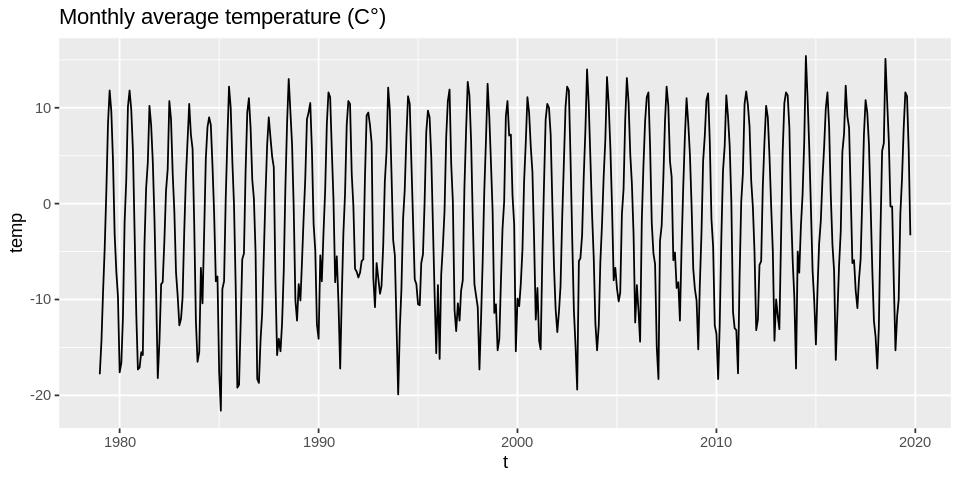

In [8]:
ggplot(d, aes(x=t, y=temp)) + geom_line() + labs(title = "Monthly average temperature (C°)")

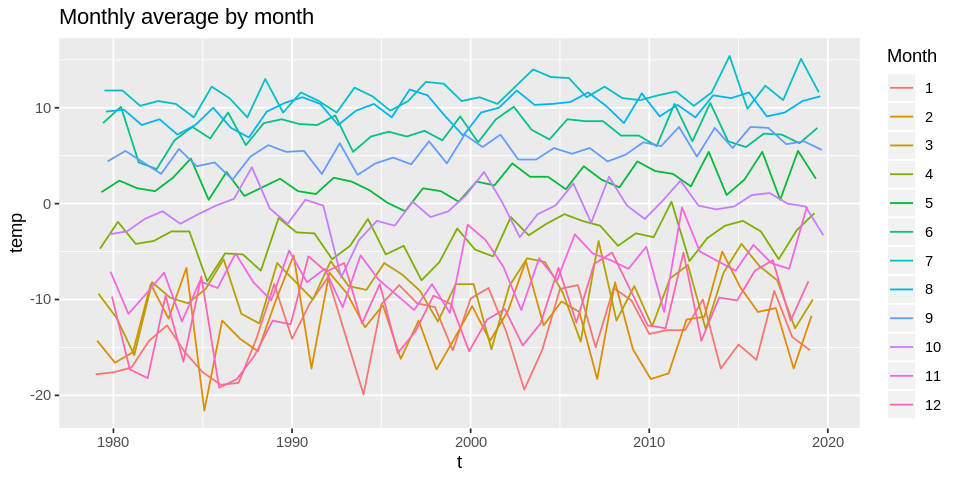

In [9]:
ggplot(d, aes(x=t, y=temp, color=f_month)) + geom_line() + labs(title = "Monthly average by month", color= "Month")

An upward trend is obvious. Note high variance of the winter months!

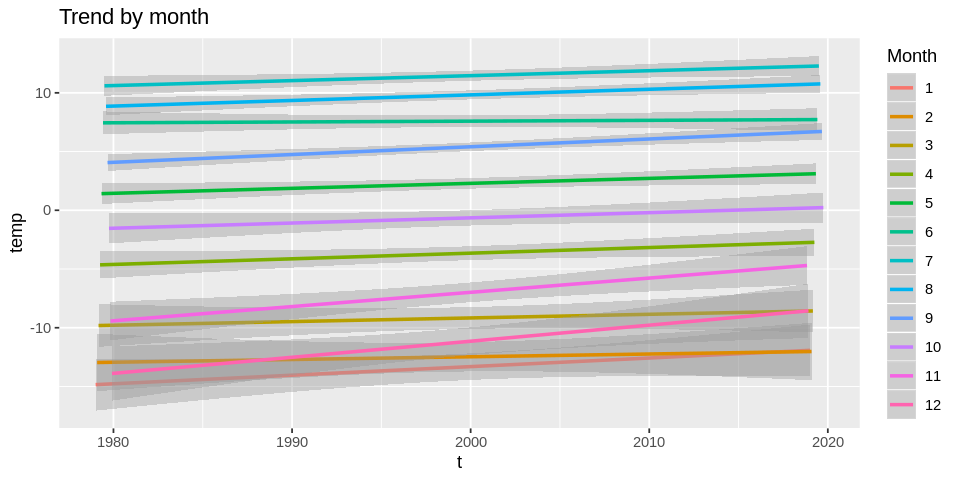

In [10]:
ggplot(d, aes(x=t, y=temp, color=f_month)) + geom_smooth(method="lm") + labs(title = "Trend by month", color= "Month")

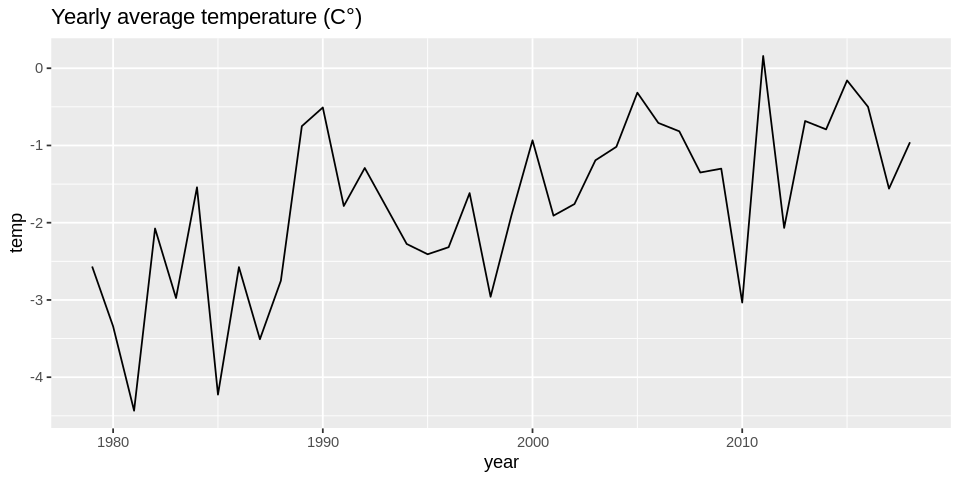

In [11]:
d_year <- d %>% group_by(year) %>% summarise(n=n(), temp=mean(temp), decade=mean(decade)) %>% filter(n==12)

ggplot(d_year, aes(x=year, y=temp)) + geom_line() + labs(title = "Yearly average temperature (C°)")

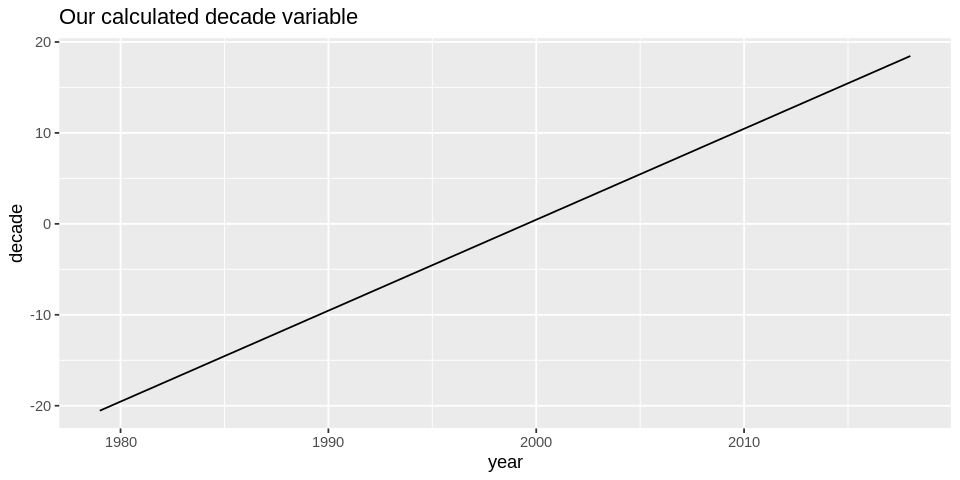

In [12]:
# Our calculated decade variable is just distance from 1.1.2000 in years. It's the time variable with a sane variance.
ggplot(d_year, aes(x=year, y=decade)) + geom_line() + labs(title = "Our calculated decade variable")

In [0]:
stan_data_yearly <- with(d_year, list(N=length(temp), decade=decade, temp=temp))

In [0]:
compile_and_fit_model <- function(model_code, data, vars_of_interest) {
  stan_start_time <- Sys.time()
  model <- stan_model(model_code = model_code) # compilation takes time if model is changed
  fit <- sampling(model, data = data)
  message("Compilation and fitting in secs ", difftime(Sys.time(), stan_start_time, units="secs"))
  
  posterior <- as.matrix(fit)
  print(traceplot(fit))
  print(fit)

  # Print posterior distributions for interesting variables
  posterior <- as.matrix(fit)
  for (var_name in vars_of_interest)
  {
    plot <- mcmc_areas(posterior, pars = c(var_name), prob = 0.8)  + 
      ggtitle(paste("Variable ", var_name, " posterior distributions with median and 80% interval"))
    print(plot)  
  }

  message("Total duration in secs ", difftime(Sys.time(), stan_start_time, units="secs"))
  return(fit)
}

The first model is a linear regression on the data aggregated to yearly level.

recompiling to avoid crashing R session
Compilation and fitting in secs 70.6229469776154


Inference for Stan model: 1ba1786ebbac82d7206777eaaf7e168e.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean   sd   2.5%    25%    50%    75%  97.5% n_eff Rhat
a      -1.71    0.00 0.14  -1.99  -1.81  -1.71  -1.62  -1.42  3667    1
b       0.06    0.00 0.01   0.04   0.05   0.06   0.07   0.08  4110    1
sigma   0.90    0.00 0.11   0.72   0.82   0.89   0.96   1.13  2896    1
lp__  -14.47    0.03 1.21 -17.50 -15.05 -14.19 -13.57 -13.07  2066    1

Samples were drawn using NUTS(diag_e) at Sat Dec  7 16:36:55 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


Total duration in secs 72.0026342868805


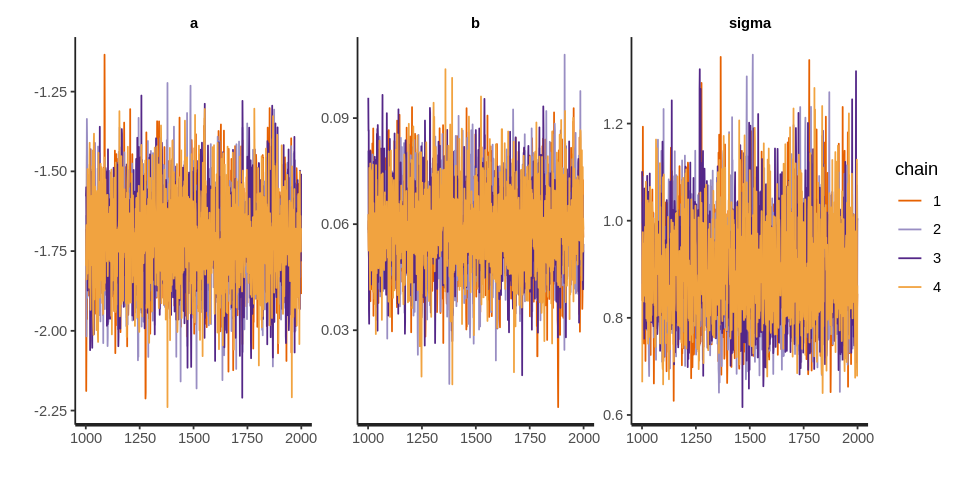

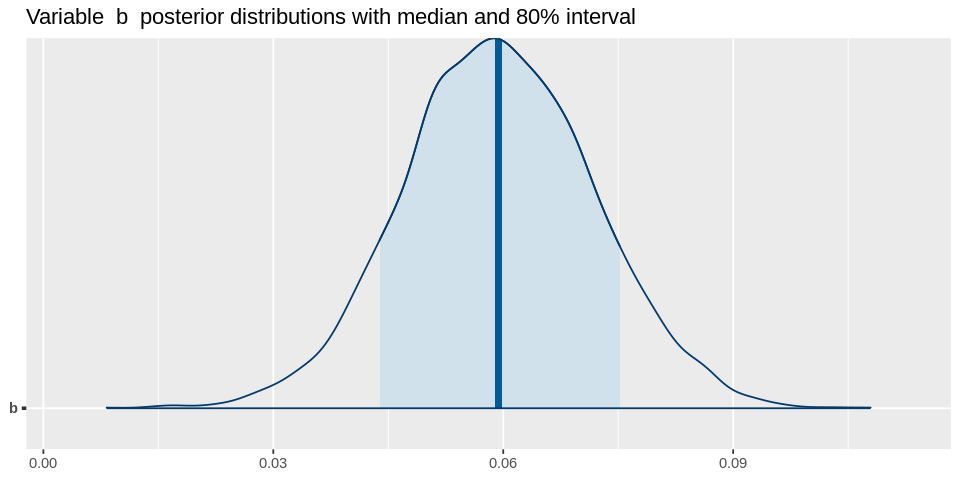

In [16]:
model_simple_normal <- "
data {
  int<lower=0> N;
  vector[N] decade;
  vector[N] temp;
}
parameters {
  real a;
  real b;
  real<lower=0> sigma;
}
model {
  temp ~ normal(a + b * decade, sigma);
}
"
fit_sn <- compile_and_fit_model(model_code = model_simple_normal, data = stan_data_yearly, vars_of_interest = c("b"))


In the second model, we take monthly data, and fit linear regression lines to each of the months separately. 

In [0]:
stan_data_monthly <- with(d, list(N=length(temp), decade=decade, month=as.integer(f_month), temp=temp))

Compilation and fitting in secs 6.84326529502869
'pars' not specified. Showing first 10 parameters by default.


Inference for Stan model: 9a2d1e14cab629b91a257d84eadcb8b4.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

             mean se_mean   sd    2.5%     25%     50%     75%   97.5% n_eff
sigma[1]     3.63    0.01 0.44    2.90    3.33    3.59    3.89    4.59  4888
sigma[2]     4.03    0.01 0.46    3.24    3.72    3.99    4.31    5.09  4733
sigma[3]     3.01    0.00 0.35    2.40    2.76    2.98    3.22    3.76  5180
sigma[4]     1.93    0.00 0.22    1.55    1.77    1.91    2.06    2.43  5005
sigma[5]     1.47    0.00 0.17    1.18    1.35    1.45    1.57    1.86  5091
sigma[6]     1.61    0.00 0.19    1.29    1.48    1.60    1.73    2.04  4426
sigma[7]     1.41    0.00 0.17    1.14    1.30    1.40    1.51    1.79  4863
sigma[8]     1.26    0.00 0.15    1.01    1.15    1.24    1.35    1.59  5308
sigma[9]     1.20    0.00 0.14    0.96    1.10    1.18    1.28    1.52  4600
sigma[10]    2.12    0.00 0.25    1.70    1.95    2.

Total duration in secs 8.63831448554993


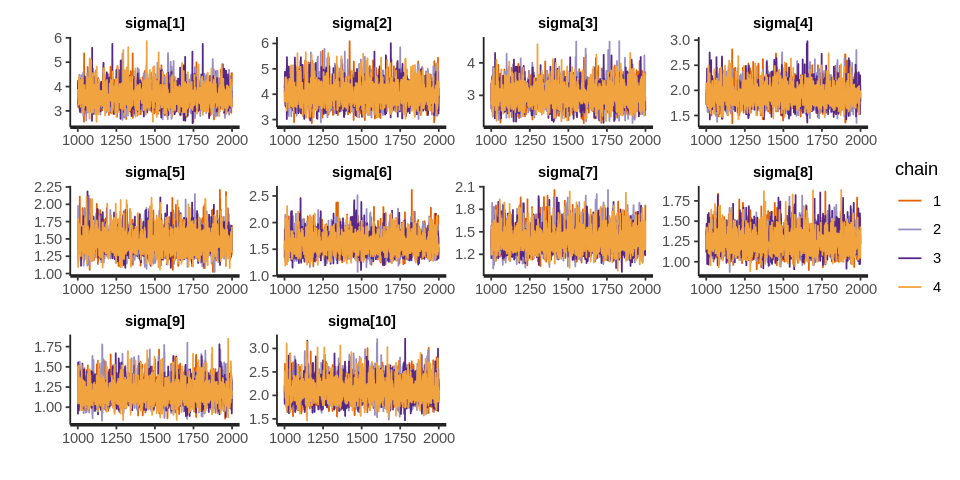

In [22]:

monthly_model_code <- "
data {
  int N;
  real decade[N];
  real temp[N];
  int month[N];
}
parameters {
  real<lower=0> sigma[12];
  real b[12];
  real k[12];
}
model {
  for (i in 1:N) {
     int m = month[i];
     temp[i] ~ normal(k[m] * decade[i] + b[m], sigma[m]); }
  sigma ~ normal(0, 5);
  b ~ normal(0, 5);
  k ~ normal(0, 1);
}
"
fit <- compile_and_fit_model(model_code = monthly_model_code, data = stan_data_monthly, vars_of_interest = c())

You can plot samples of the model, for example by variable pairs.

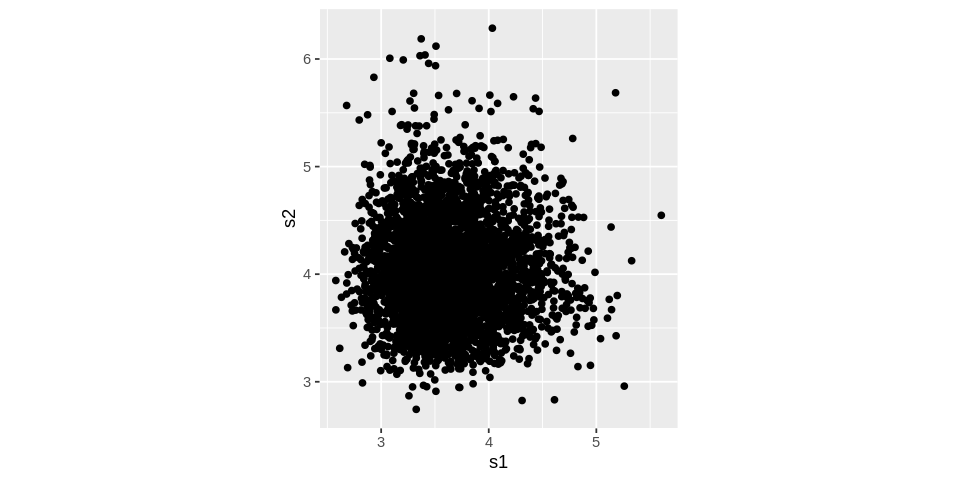

In [51]:
data.frame(s1=extract(fit, "sigma[1]")[[1]], s2=extract(fit, "sigma[2]")[[1]]) %>% ggplot(aes(x=s1, y=s2)) + geom_point() + coord_equal()

Below, the change of temperature per decade, by month. Note the higher uncertainty of winter months!

ci_level: 0.8 (80% intervals)
outer_level: 0.95 (95% intervals)


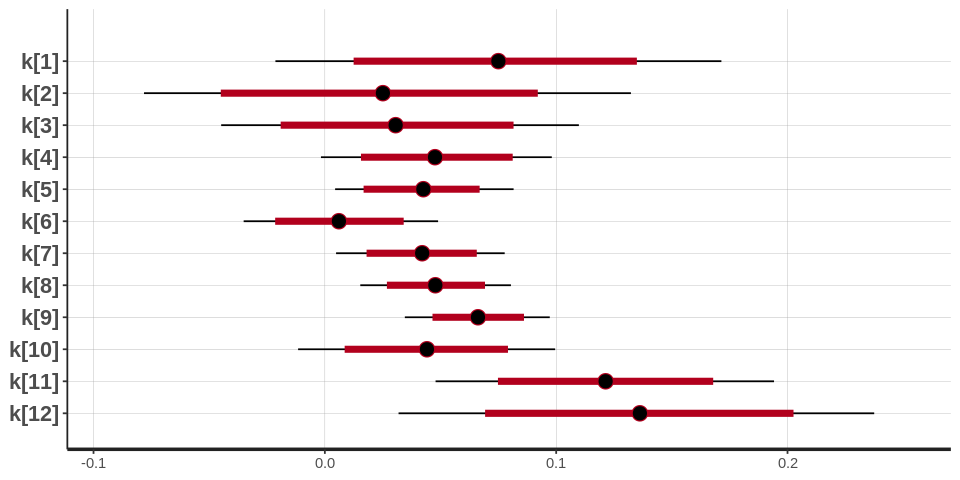

In [32]:
plot(fit, pars="k")

Winter months also have higher residual variance.

ci_level: 0.8 (80% intervals)
outer_level: 0.95 (95% intervals)


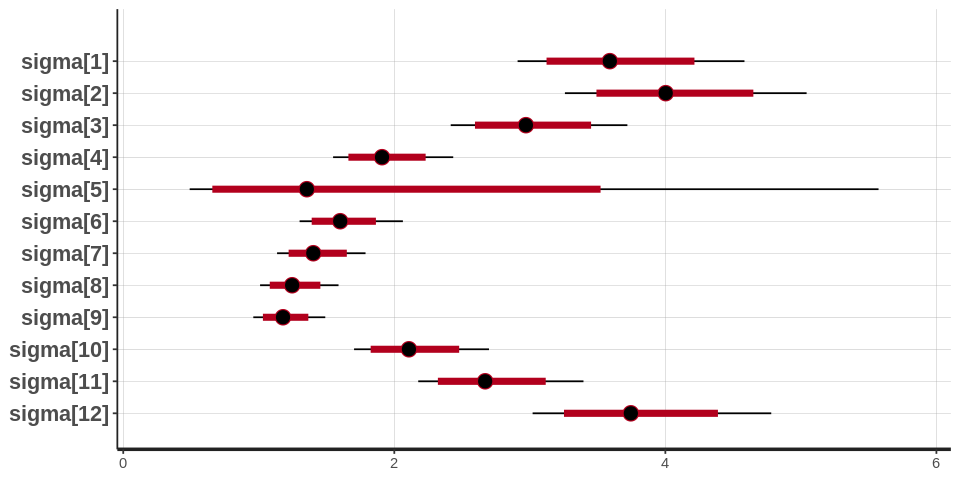

In [52]:
plot(fit, pars="sigma")

Next, remove data of some Mays, so that the estimates for May become very uncertain. Refit the model.

Warning message:
“There were 364 divergent transitions after warmup. Increasing adapt_delta above 0.8 may help. See
http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup”Warning message:
“Examine the pairs() plot to diagnose sampling problems
”Compilation and fitting in secs 9.37271976470947
'pars' not specified. Showing first 10 parameters by default.


Inference for Stan model: 9a2d1e14cab629b91a257d84eadcb8b4.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

             mean se_mean   sd    2.5%     25%     50%     75%   97.5% n_eff
sigma[1]     3.62    0.01 0.43    2.88    3.32    3.58    3.89    4.58  2640
sigma[2]     4.03    0.01 0.46    3.22    3.71    3.99    4.32    5.03  2786
sigma[3]     3.01    0.01 0.34    2.43    2.76    2.98    3.22    3.77  3160
sigma[4]     1.93    0.00 0.24    1.53    1.76    1.91    2.08    2.45  3247
sigma[5]     1.70    0.04 1.29    0.50    0.86    1.28    2.11    5.39  1099
sigma[6]     1.61    0.00 0.19    1.29    1.48    1.60    1.73    2.04  3360
sigma[7]     1.42    0.00 0.17    1.13    1.30    1.41    1.53    1.79  3124
sigma[8]     1.26    0.00 0.15    1.01    1.15    1.25    1.35    1.59  2942
sigma[9]     1.19    0.00 0.14    0.95    1.09    1.18    1.28    1.51  2871
sigma[10]    2.13    0.00 0.25    1.71    1.96    2.

Total duration in secs 10.8865494728088


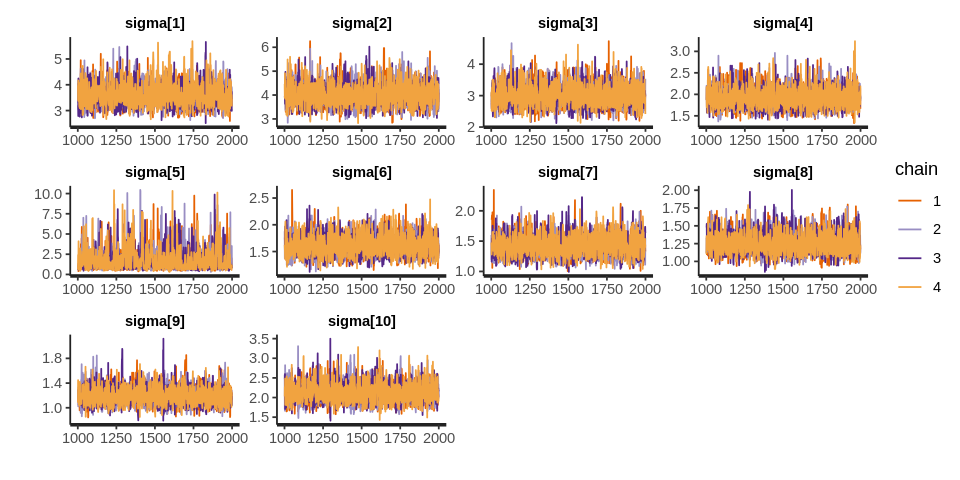

In [53]:
stan_data_monthly_censored <- with(d %>% filter(f_month != 5 | year %in% c(1980, 1986, 1988, 2003)), 
                               list(N=length(temp), decade=decade, month=as.integer(f_month), temp=temp))
fitc <- compile_and_fit_model(model_code = monthly_model_code, data = stan_data_monthly_censored, vars_of_interest = c())

ci_level: 0.8 (80% intervals)
outer_level: 0.95 (95% intervals)


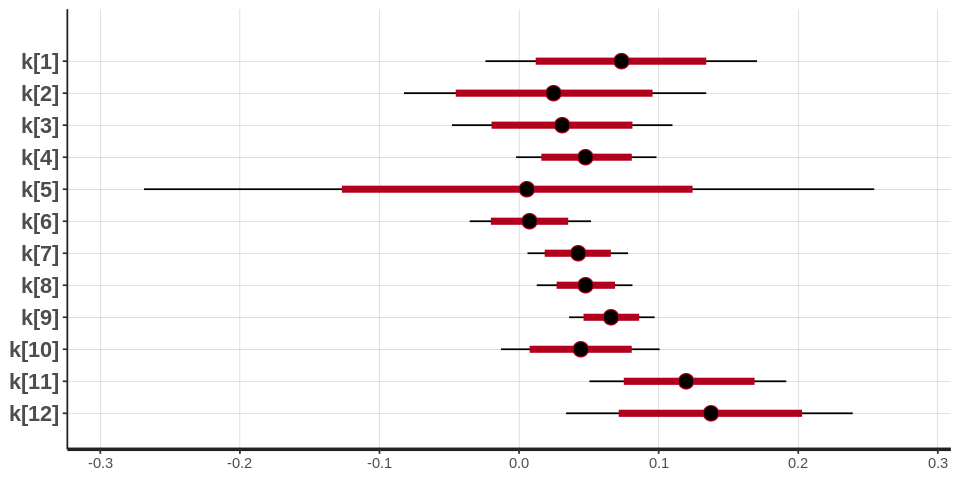

In [54]:
plot(fit, pars="k")

Compilation and fitting in secs 78.9285724163055
'pars' not specified. Showing first 10 parameters by default.


Inference for Stan model: a22b325795b4e159dde49f0aeaeb57b6.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

             mean se_mean   sd    2.5%     25%     50%     75%   97.5% n_eff
sigma[1]     3.61    0.01 0.42    2.91    3.32    3.58    3.88    4.53  4569
sigma[2]     4.01    0.01 0.46    3.23    3.68    3.97    4.29    5.05  3981
sigma[3]     3.00    0.01 0.34    2.43    2.75    2.96    3.20    3.74  4179
sigma[4]     1.92    0.00 0.22    1.54    1.77    1.90    2.06    2.42  3970
sigma[5]     1.47    0.00 0.17    1.17    1.34    1.45    1.57    1.83  3896
sigma[6]     1.61    0.00 0.19    1.30    1.48    1.59    1.73    2.03  4013
sigma[7]     1.42    0.00 0.16    1.14    1.30    1.40    1.52    1.78  4131
sigma[8]     1.26    0.00 0.15    1.01    1.15    1.24    1.35    1.57  4280
sigma[9]     1.20    0.00 0.14    0.96    1.10    1.18    1.28    1.51  3943
sigma[10]    2.13    0.00 0.25    1.72    1.96    2.

Total duration in secs 80.5007960796356


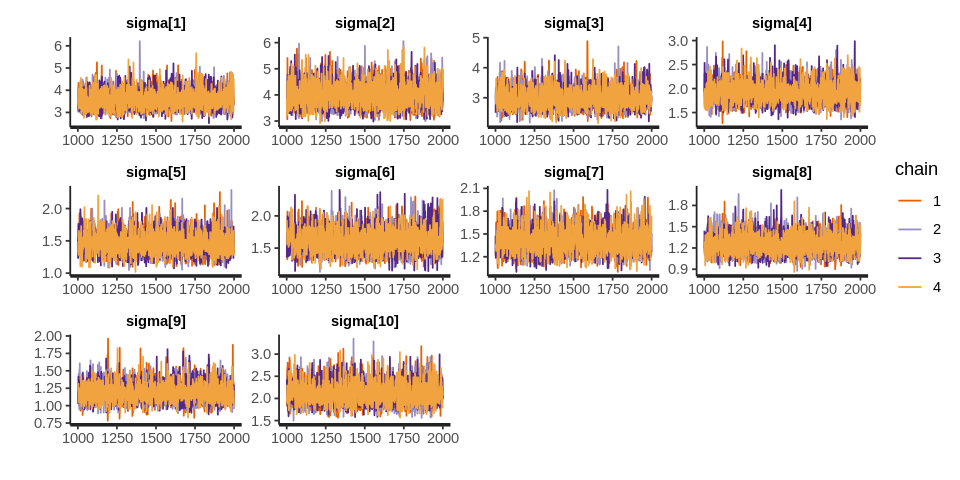

In [55]:
monthly_model_code_hier <- "
data {
  int N;
  real decade[N];
  real temp[N];
  int month[N];
}
parameters {
  real<lower=0> sigma[12];
  real<lower=0> sigma_k;
  real<lower=0> sigma_b;
  real b[12];
  real k[12];
}
model {
  for (i in 1:N) {
     int m = month[i];
     temp[i] ~ normal(k[m] * decade[i] + b[m], sigma[m]); }
  sigma ~ normal(0, 5);
  b ~ normal(0, sigma_b);
  k ~ normal(0, sigma_k);
}
"
fith <- compile_and_fit_model(model_code = monthly_model_code_hier, data = stan_data_monthly, vars_of_interest = c())

ci_level: 0.8 (80% intervals)
outer_level: 0.95 (95% intervals)


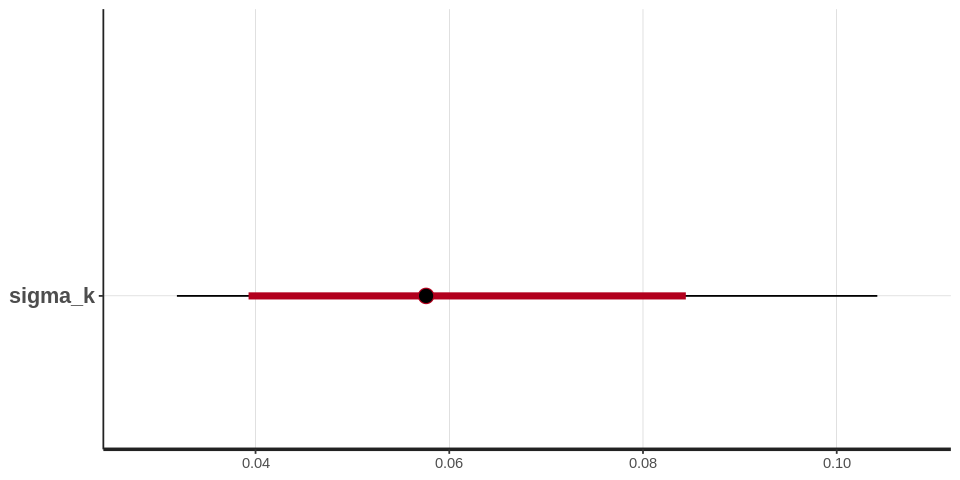

In [35]:
plot(fith, pars="sigma_k")

ci_level: 0.8 (80% intervals)
outer_level: 0.95 (95% intervals)
ci_level: 0.8 (80% intervals)
outer_level: 0.95 (95% intervals)


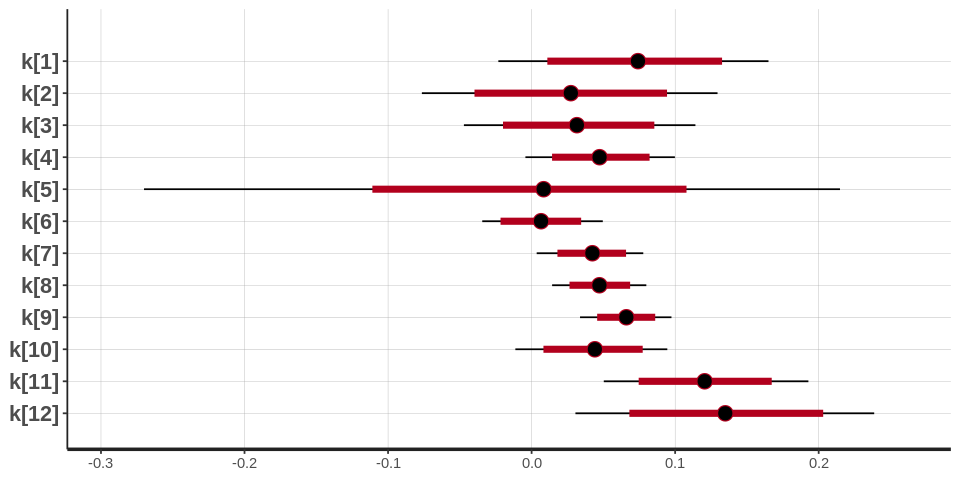

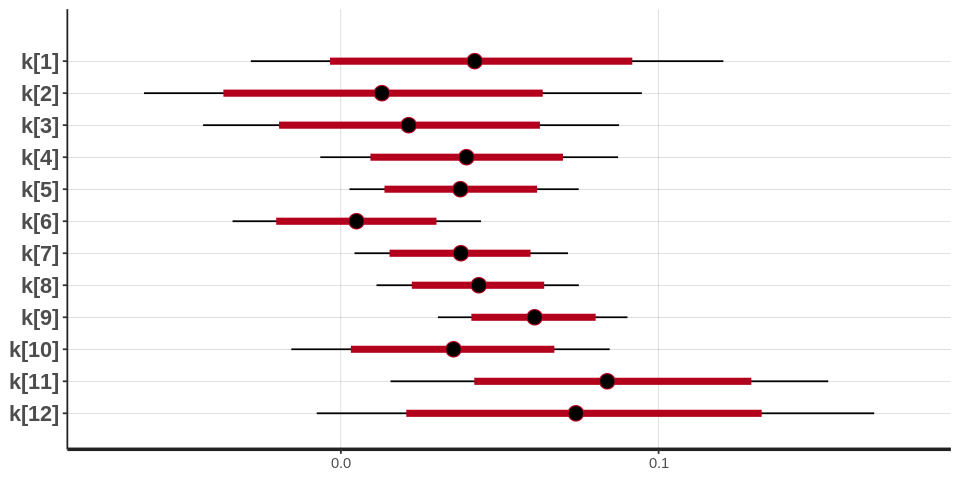

In [56]:
plot(fitc, pars="k")
plot(fith, pars="k")

ci_level: 0.8 (80% intervals)
outer_level: 0.95 (95% intervals)


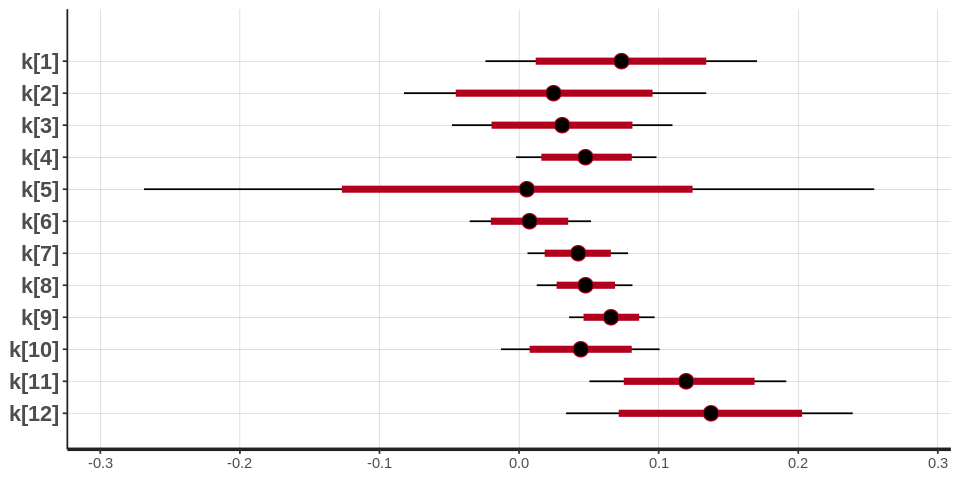

In [48]:
plot(fit, pars="k")

ci_level: 0.8 (80% intervals)
outer_level: 0.95 (95% intervals)


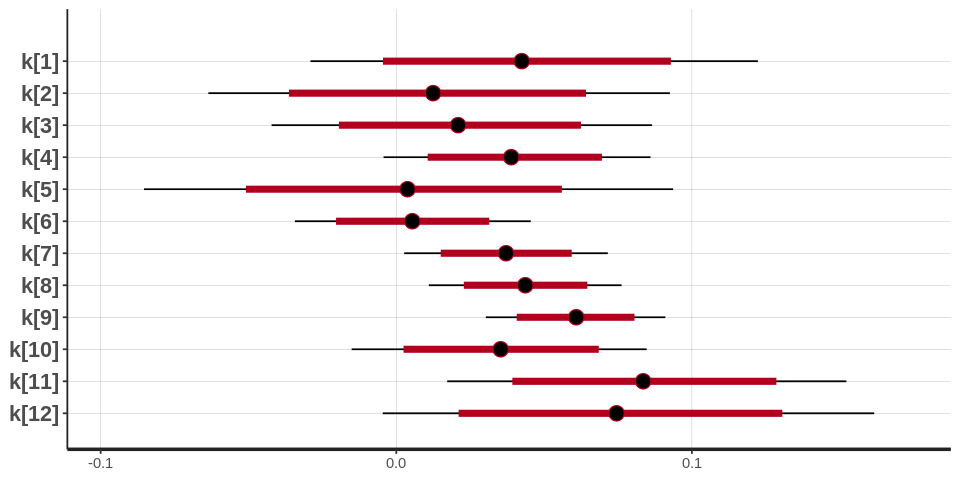

In [49]:
plot(fith, pars="k")